# Carga de datos

In [1]:
# Crear la carpeta data si no existe
!mkdir -p data

# Descargar el archivo y guardarlo en la carpeta data
!wget -P data https://raw.githubusercontent.com/jamezahidalgo/datos/master/Concentracio%CC%81n_de_Minerales.csv


--2024-08-07 14:40:38--  https://raw.githubusercontent.com/jamezahidalgo/datos/master/Concentracio%CC%81n_de_Minerales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5764305 (5.5M) [text/plain]
Saving to: ‘data/Concentración_de_Minerales.csv’

Concentracio%cc%81n 100%[===================>]   5.50M  --.-KB/s    in 0.1s    

2024-08-07 14:40:38 (57.5 MB/s) - ‘data/Concentración_de_Minerales.csv’ saved [5764305/5764305]



In [9]:
# Crear la carpeta data si no existe
!mkdir -p config

# Descargar el archivo y guardarlo en la carpeta data
!wget -P config https://raw.githubusercontent.com/jamezahidalgo/datos/master/config.json


--2024-08-07 14:43:28--  https://raw.githubusercontent.com/jamezahidalgo/datos/master/config.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 992 [text/plain]
Saving to: ‘config/config.json’

config.json         100%[===================>]     992  --.-KB/s    in 0s      

2024-08-07 14:43:28 (48.8 MB/s) - ‘config/config.json’ saved [992/992]



# Instalación librerias

In [3]:
!pip install nltk scikit-learn

# Importación de librerías

In [4]:
import pandas as pd
import numpy as np
import nltk
import string
import warnings
import re
import wordcloud
import json
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import GridSearchCV

# Ignorar SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Funciones generales

In [66]:
def getTerminos(source : str):
    # Abrir y leer el archivo JSON
    with open(source, 'r') as file:
        datos = json.load(file)
    return datos

def preprocess_text_v(text):
	# Definir stopwords y puntuación
	stop_words = set(stopwords.words('english'))
	punctuation = set(string.punctuation)
    # Convertir a string y manejar NaN
	if isinstance(text, float):
		return []
    # Tokenizar el texto
	tokens = word_tokenize(text.lower())
	text = text.translate(str.maketrans('', '', string.punctuation))
	# Filtrar stopwords y puntuación
	tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
	return tokens

# Obtiene la frecuencia de cada término en el periodo indicado
def terms_by_period(data : pd.DataFrame, periodo: int, tokens : np.array):
  periodo = data[data['year'] == periodo]
  lst_frequency = []
  for termino in tokens:
    total = 0
    for row in periodo['tokens']:
      if termino in row:
        total += 1
    lst_frequency.append((termino, total))

  palabras_ordenadas = sorted(lst_frequency, key=lambda item: item[1], reverse=True)
  palabras, frecuencias = zip(*palabras_ordenadas)
  return palabras, frecuencias

# Obtiene las frecuencias de un período de las categorías
def categories_by_period(data : pd.DataFrame, periodo : int, categorias : np.array):
  """
  Obtiene las frecuencias de un período de las categorías.

  Args:
      data (pd.DataFrame): data frame que contiene los datos.
      periodo (int): Año de consulta.
      categorias: colección con las categorias a analizar

  Returns:
      list: colección con las frecuencias de cada categoría.

  Raises:
      None.
  """
  frecuencias = []
  total = 0
  for categoria in categorias:
    data_target = data[data['year'] == periodo]
    x_frecuencias = get_frequency(data_target = data_target,
                            terminos = categoria["terminos"])

    total = np.sum(np.fromiter((tupla[1] for tupla in x_frecuencias), dtype=int))
    frecuencias.append((categoria["nombre"], total))

  return frecuencias

def get_frequency(data_target : pd.DataFrame, terminos : np.array):
	lst_frequency = []
	for termino in terminos:
		total = 0
		for row in data_target['tokens']:
			if termino in row:
				total += 1
		lst_frequency.append((termino, total))
	return lst_frequency

def get_all_frequency(data : pd.DataFrame, categorias : np.array, inicio : int, final : int):
  data_grafica = []
  # Obtiene la lista de categorías
  lst_categorias = [categoria['nombre'] for categoria in categorias]
  for categoria in lst_categorias:
    lst_grafica = [categoria, np.zeros(final - inicio + 1)]
    # Convertir cada carácter a un entero
    lst_grafica = np.concatenate([np.array([lst_grafica[0]]),
                                  [int(char) for char in lst_grafica[1]]])
    indice = 1
    # Obtiene los términos de la categoria
    terminos = obtener_terminos_por_categoria(categoria, categorias)

    # Buscar la frecuencia en cada período
    for x_periodo in range(inicio, final+1):
      # Obtiene la frecuencia de los términos en el periodo indicado
      _, x_frequencies = terms_by_period(data_target, x_periodo, terminos)
      lst_grafica[indice] = np.sum(x_frequencies)
      indice += 1
    data_grafica.append(lst_grafica)
  lst_columns = ['categoria', range(inicio, final+1)]
  lst_columns = np.concatenate([np.array([lst_columns[0]]), lst_columns[1]])

  data_frame = pd.DataFrame(data_grafica, columns = lst_columns)
  lst_frequency = data_frame.columns[1:]

  data_frame[lst_frequency] = data_frame[lst_frequency].astype(int)
  return data_frame

def count_terms(abstracts, terms):
    counter = Counter()
    for abstract in abstracts:
        for term in terms:
            counter[term] += abstract.count(term)
    return counter

# Función para obtener los términos dado una categoria
def obtener_terminos_por_categoria(nombre : str, coleccion : np.array):
    for categoria in coleccion:
        if categoria['nombre'] == nombre:
            return categoria['terminos']
    return None

# Funciones para gráficas

In [6]:
def view_graph_terms(lst_frequency : np.array, all_inclusive = True):
  if not all_inclusive:
    lst_frequency = [tupla for tupla in lst_frequency if tupla[1] > 0]

  palabras_ordenadas = sorted(lst_frequency, key=lambda item: item[1], reverse=True)
  palabras, frecuencias = zip(*palabras_ordenadas)

  plt.figure(figsize=(6, 6))
  plt.barh(palabras, frecuencias, color='skyblue')
  plt.xlabel('Frecuencia', fontsize=16, fontweight="bold")
  plt.ylabel('Categoría', fontsize=16, fontweight="bold")
  plt.title('Frecuencia de los términos 4.0', fontsize=20, fontweight="bold")
  plt.gca().invert_yaxis()  # Para que la categoria con mayor frecuencia esté arriba
  plt.show()

def graph_by_period(data_target : pd.DataFrame, periodo : int, terminos : np.array):
  words, frequencies = terms_by_period(data_target, periodo, terminos)
  plt.figure(figsize=(6, 6))
  plt.barh(words, frequencies, color='skyblue')
  plt.xlabel('Frecuencia', fontsize=16, fontweight="bold")
  plt.ylabel('Término 4.0', fontsize=16, fontweight="bold")
  plt.title('Frecuencia de los términos 4.0\naño {}'.format(periodo), fontsize=18, fontweight="bold")
  plt.gca().invert_yaxis()  # Para que la palabra con mayor frecuencia esté arriba
  plt.show()

def graph_complete(data_target : pd.DataFrame, inicio : int, final : int, categorias : np.array):
  # Crear una figura y un conjunto de subplots
  fig, axs = plt.subplots(3, 2, figsize=(15, 20))
  for i, periodo in enumerate(range(inicio, final+1)):
    row, col = divmod(i, 2)

    nombres = [categoria['nombre'] for categoria in categorias]

    frequencies = []
    for categoria in nombres:
      terminos = obtener_terminos_por_categoria(categoria, categorias)
      words, x_frequencies = terms_by_period(data_target, periodo, terminos)
      total = np.sum(x_frequencies) #np.sum(np.fromiter((tupla[1] for tupla in x_frequencies), dtype=int))

      frequencies.append((categoria, total))

    frecuencias_ordenadas = sorted(frequencies, key=lambda item: item[1], reverse=True)
    n_categorias, frecuencias = zip(*frecuencias_ordenadas)

    axs[row, col].barh(n_categorias, frecuencias, color='skyblue')
    axs[row, col].set_title(f'Año {periodo}', fontsize=18, fontweight="bold")
    axs[row, col].invert_yaxis()  # Para que la categoria con mayor frecuencia esté arriba

  # Eliminar el subplot extra si hay un número impar de gráficos
  if len(range(inicio, final+1)) % 2 != 0:
    fig.delaxes(axs[-1, -1])

  # Ajustar el diseño para evitar la superposición
  plt.tight_layout()

  fig.suptitle("Frecuencias para cada período", fontsize=20, fontweight="bold")
  # Ajustar el layout para que los títulos no se solapen
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  # Mostrar el gráfico
  plt.show()

# Funcionamiento

## Descarga recursos de NLTK

In [7]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Carga de datos de configuración

+ Lista de categorías y los términos que pertenecen a cada una
+ Nombre del CSV de las patentes

In [65]:
# Abrir y leer el archivo JSON
ruta_archivo = "config/config.json"
with open(ruta_archivo, 'r') as file:
  datos = json.load(file)
datos = getTerminos(ruta_archivo)

print("Lista de categorías disponibles")
for categoria in datos["categorias"]:
  print(f"\t{categoria['nombre']} con {len(categoria['terminos'])} términos")


Lista de categorías disponibles
	Tecnologías de Inteligencia con 6 términos
	Tecnologías de automatización con 8 términos
	Tecnologías de simulación e inmersión con 8 términos
	Tecnologías relacionadas a datos con 4 términos
	Tecnologías de impresión 3d con 1 términos


In [12]:
ruta_data = "data/" + datos["csv"]
data = pd.read_csv(ruta_data)
print("Se han cargado {} patentes".format(data.shape[0]))

Se han cargado 3192 patentes


In [13]:
data.columns = data.columns.str.lower().str.replace(" ", "_", regex=True)
# Extracción de las variables de interes
data_target = data[['title', 'abstract','publication_date']]
data_target["year"] =  pd.to_datetime(data_target['publication_date']).dt.year
# Aplicar el preprocesamiento a la columna de abstracts
data_target['tokens'] = data_target['abstract'].apply(preprocess_text_v)
# Obtiene las frecuencias
frecuencias = []
total = 0
for categoria in datos["categorias"]:
  x_frecuencias = get_frequency(data_target = data_target,
                            terminos = categoria["terminos"])
  #total = np.sum(tupla[1] for tupla in frecuencias)
  total = np.sum(np.fromiter((tupla[1] for tupla in x_frecuencias), dtype=int))
  frecuencias.append((categoria["nombre"], total))

frecuencias

[('Tecnologías de Inteligencia', 84),
 ('Tecnologías de automatización', 754),
 ('Tecnologías de simulación e inmersión', 163),
 ('Tecnologías relacionadas a datos', 2136),
 ('Tecnologías de impresión 3d', 25)]

## Gráficos de frecuencias - términos 4.0

In [14]:
# Obtiene el año de inicio y de término según lo indica la data
inicio, fin = np.min(data_target['year']), np.max(data_target['year'])

### Frecuencias de términos en general

In [17]:
# Muestra la tabla de frecuencias de términos
pd.DataFrame(frecuencias, columns = ['categoria', 'frecuencia']).sort_values(by="frecuencia", ascending=False)

,categoria,frecuencia
3,Tecnologías relacionadas a datos,2136
1,Tecnologías de automatización,754
2,Tecnologías de simulación e inmersión,163
0,Tecnologías de Inteligencia,84
4,Tecnologías de impresión 3d,25


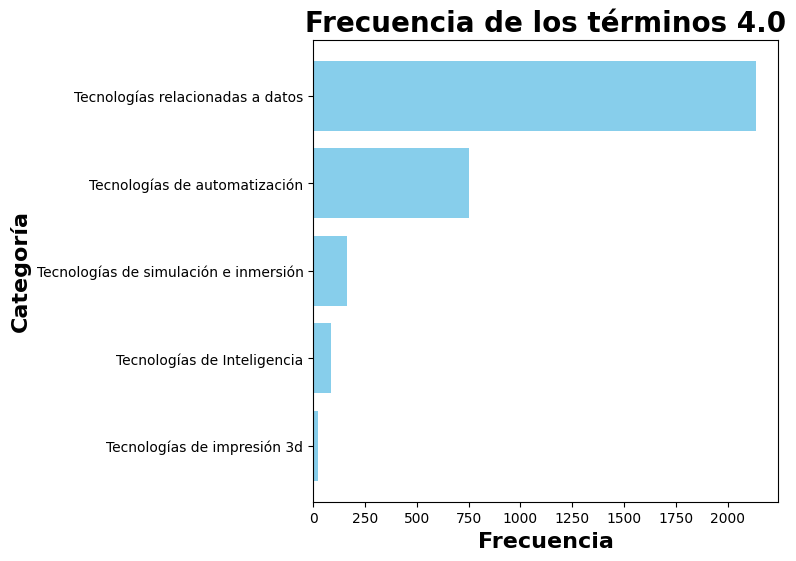

In [18]:
# Ver gráfico de frecuencias de las categorías
view_graph_terms(frecuencias)

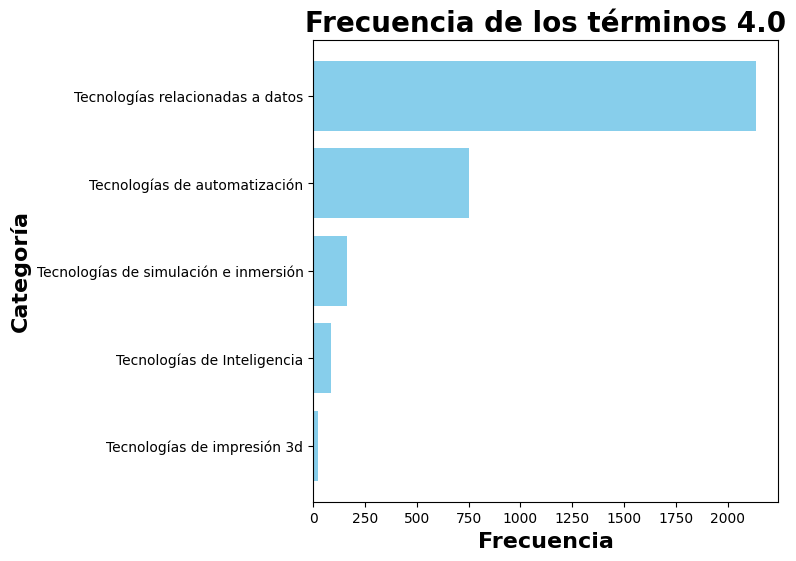

In [20]:
# Ver gráfico de frecuencias de los categorías considerando solo los que presentan frecuencia
view_graph_terms(frecuencias, False)

### Frecuencias por período

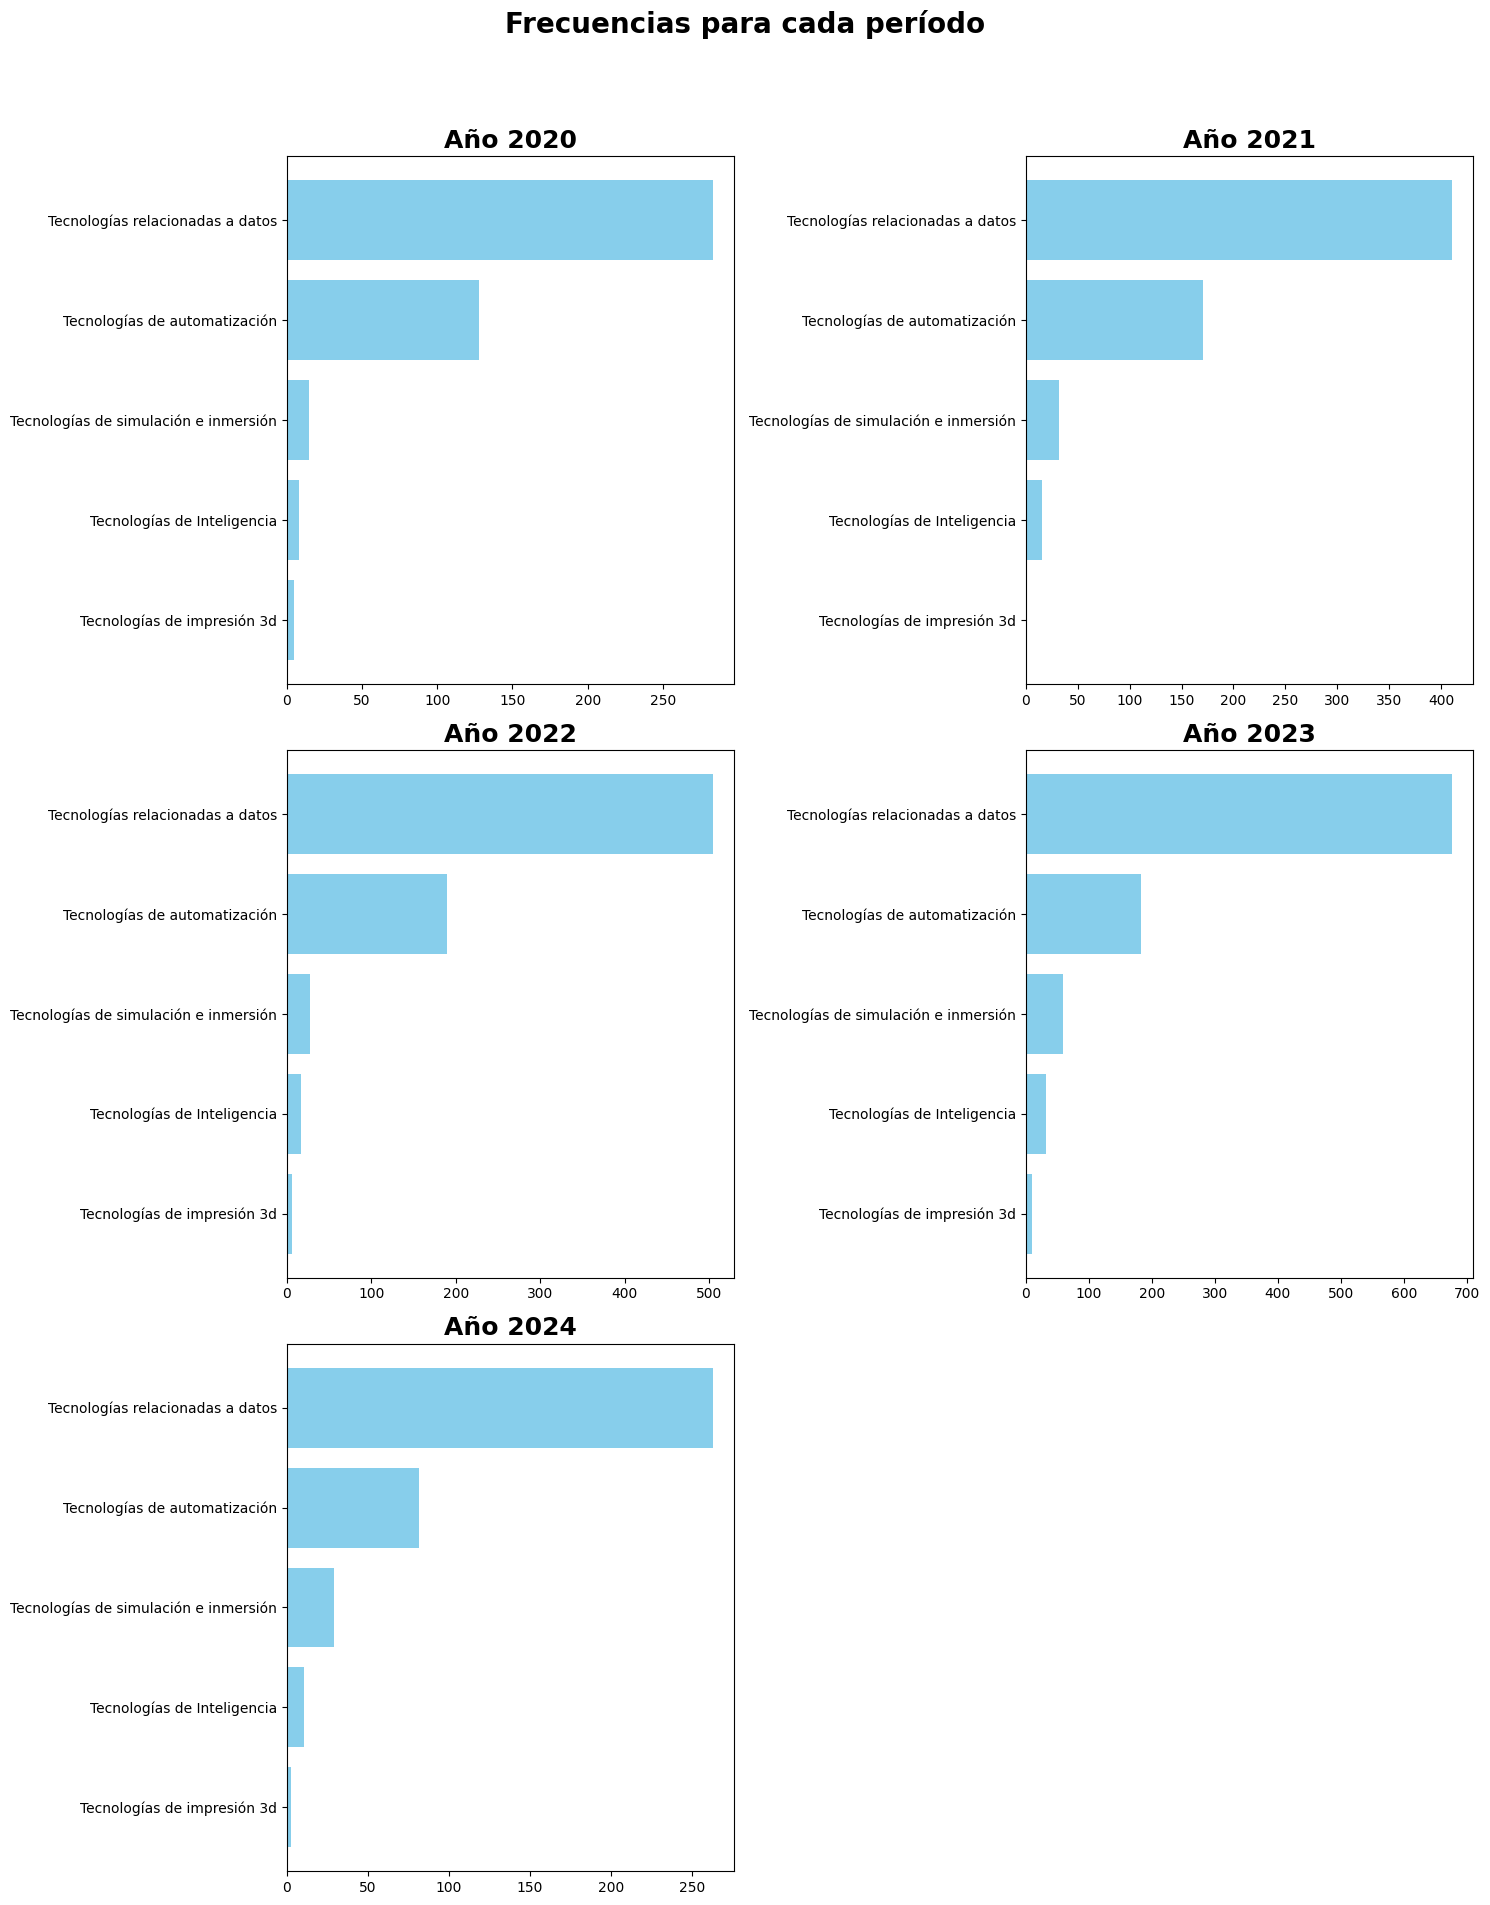

In [21]:
# Genera las gráficas de frecuencias de cada período
graph_complete(data_target = data_target, inicio = inicio,
               final = fin, categorias= datos["categorias"])

## Evolución de términos en los años

In [67]:
data_frecuencia = get_all_frequency(data=data_target, categorias=datos["categorias"], inicio = inicio, final = fin)
data_frecuencia

,categoria,2020,2021,2022,2023,2024
0,Tecnologías de Inteligencia,8,16,17,32,11
1,Tecnologías de automatización,128,171,190,183,82
2,Tecnologías de simulación e inmersión,15,32,28,59,29
3,Tecnologías relacionadas a datos,283,410,504,676,263
4,Tecnologías de impresión 3d,5,1,6,10,3


In [61]:
data_frecuencia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   categoria  5 non-null      object
 1   2020       5 non-null      int64 
 2   2021       5 non-null      int64 
 3   2022       5 non-null      int64 
 4   2023       5 non-null      int64 
 5   2024       5 non-null      int64 
dtypes: int64(5), object(1)
memory usage: 368.0+ bytes


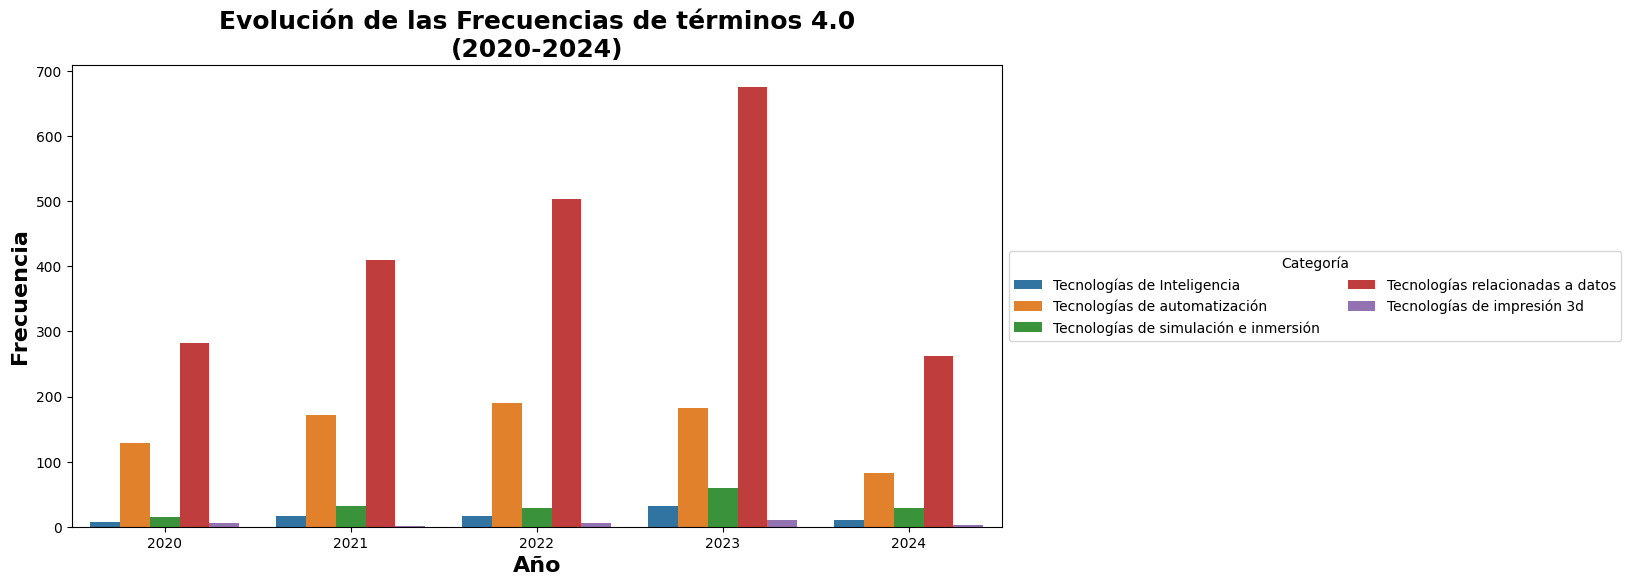

In [63]:
# Transformar el DataFrame a formato largo
df_long = pd.melt(data_frecuencia, id_vars=['categoria'], var_name='Año', value_name='Frecuencia')

# Gráfico de barras agrupadas
plt.figure(figsize=(12, 6))
sns.barplot(data=df_long, x='Año', y='Frecuencia', hue='categoria')

# Personalizar el gráfico
plt.title(f'Evolución de las Frecuencias de términos 4.0\n({inicio}-{fin})', fontsize=18, fontweight="bold")
plt.xlabel('Año', fontsize=16, fontweight="bold")
plt.ylabel('Frecuencia', fontsize=16, fontweight="bold")
plt.legend(title='Categoría', loc="center left", bbox_to_anchor=(1, 0.5), ncol=2)
plt.show()

In [44]:
data_frecuencia.columns

Index(['categoria', '2020', '2021', '2022', '2023', '2024'], dtype='object')

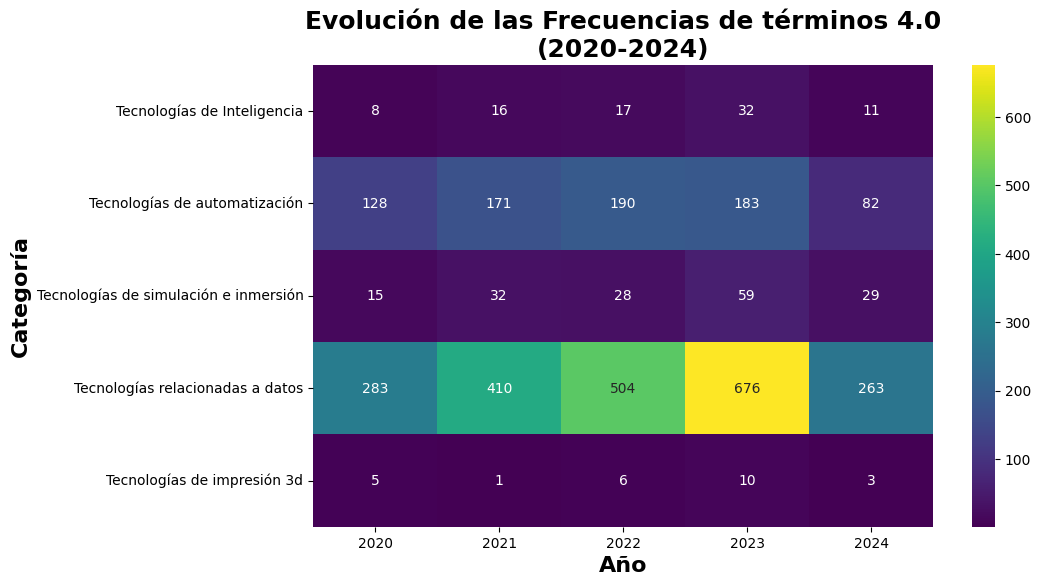

In [45]:
# Establecer la columna 'categoria' como índice
data_frecuencia.set_index('categoria', inplace=True)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data_frecuencia, annot=True, cmap='viridis', fmt='g')

# Personalizar el gráfico
plt.title(f'Evolución de las Frecuencias de términos 4.0\n({inicio}-{fin})',
          fontsize=18, fontweight="bold")
plt.xlabel('Año', fontsize=16, fontweight="bold")
plt.ylabel('Categoría', fontsize=16, fontweight="bold")
plt.show()

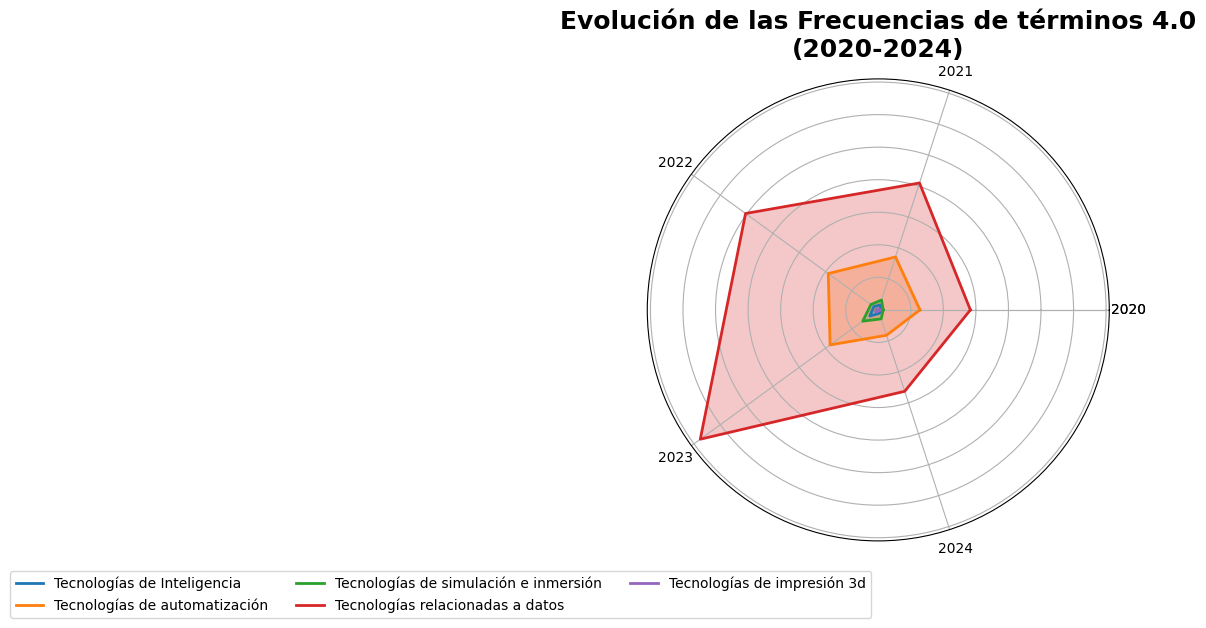

In [46]:
# Añadir la primera columna al final para cerrar el gráfico de radar
data_frecuencia  = data_frecuencia .T
categories = list(data_frecuencia.index)
num_vars = len(categories)

# Ángulos del gráfico de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
# Hacer un gráfico de radar para cada palabra
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))

for i, palabra in enumerate(data_frecuencia.columns):
    values = data_frecuencia[palabra].tolist()
    values += values[:1]  # Cerrar el gráfico
    ax.plot(angles, values, label=palabra, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

# Ajustes de visualización
ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(categories + [categories[0]])

plt.title(f'Evolución de las Frecuencias de términos 4.0\n({inicio}-{fin})', fontsize=18, fontweight="bold")
plt.legend(loc='best', bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.show()

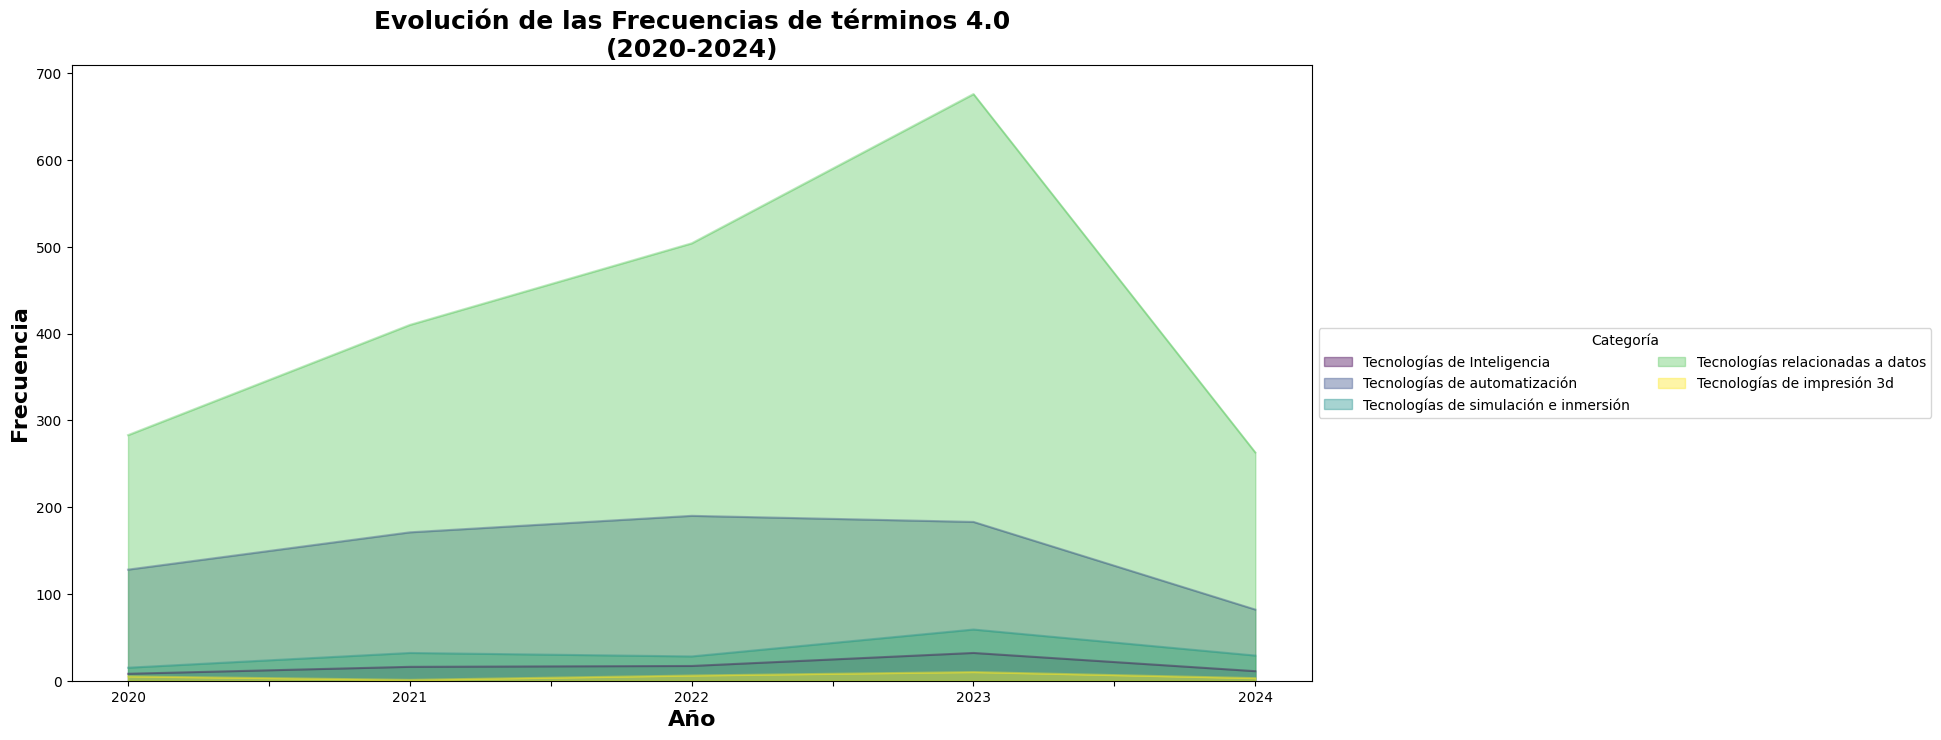

In [55]:
data_frecuencia = get_all_frequency(data=data_target, categorias=datos["categorias"], inicio = inicio, final = fin)
# Establecer la columna 'categoria' como índice
data_frecuencia.set_index('categoria', inplace=True)

# Gráfico de área apilada
data_frecuencia.T.plot(kind='area', figsize=(16, 8), stacked=False, alpha=0.4, cmap='viridis')

# Personalizar el gráfico
plt.title(f'Evolución de las Frecuencias de términos 4.0\n({inicio}-{fin})', fontsize=18,
          fontweight="bold")
plt.xlabel('Año', fontsize=16, fontweight="bold")
plt.ylabel('Frecuencia', fontsize=16, fontweight="bold")
plt.legend(title='Categoría', loc="center left", bbox_to_anchor=(1, 0.5), ncol=2)
plt.show()